## smoothing preproc images using nipype

In [1]:
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,ApplyMask,
                                   MCFLIRT, SliceTimer, Threshold, IsotropicSmooth)
from nipype.interfaces.spm import Smooth, SliceTiming
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

201007-11:24:28,332 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### check TR

In [2]:
import numpy as np
import nibabel as nib

In [3]:
func_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
header = func_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

image spatial voxel sizes (2.4 x 2.4 x 3.12)mm, TR=2s

In [4]:
print(header.get_data_shape())

(81, 96, 63, 246)


shape of image array 246 vols

In [5]:
func_img.shape[2]

63

### check mask

In [6]:
mask_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
header = mask_img.header
header.get_zooms()

(2.4, 2.4, 3.12)

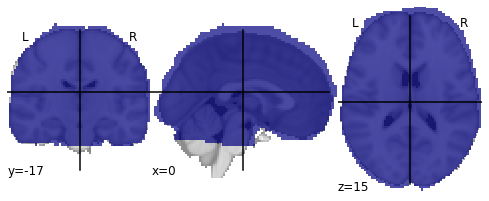

In [7]:
import nilearn.plotting
nilearn.plotting.plot_roi(mask_img)

### make average mask

In [21]:
from glob import glob
brainmasks = glob('/data/sub-*/func/*brain_mask.nii.gz')
print(brainmasks[21])

/data/sub-15/func/sub-15_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


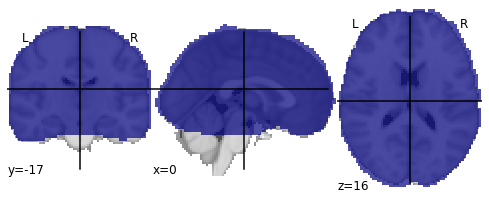

In [22]:
nilearn.plotting.plot_roi(brainmasks[21])

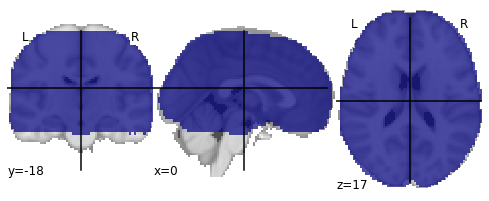

In [24]:
mean_mask = nilearn.image.mean_img(brainmasks)
# nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

### nipype smoothing workflow

In [6]:
experiment_dir = '/output'
output_dir = 'smooth_nomask'
working_dir = 'workingdir'
data_dir = '/data'

# TR of functional images
TR = 2.

In [7]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# Smooth - image smoothing
smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
# smooth = Node(IsotropicSmooth(fwhm=4), name='smooth')

### slice time correction

based on [auto detection script](https://en.wikibooks.org/wiki/SPM/Slice_Timing#cite_note-crnl-autodetect-script2-7), the data has Slice order=1, slices=31, TR= 2.000sec, TA= 1.935484sec, referenced to 1st slice. Slice indices [1,2,3...31].

fmriprep output seem to have 63 slices instead.

In [6]:
# slice time correction
from nipype.interfaces.spm import SliceTiming
slice_order = list(range(1, 32, 1))
print(slice_order)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [7]:
slicetime = Node(SliceTiming(num_slices=31,
                             ref_slice=1,
                             slice_order=slice_order,
                             time_repetition=2.,
                             time_acquisition=2.-(2./31)),
                 name='slicetime')

### specify input/output

In [8]:
sj_ls = []
for f in os.listdir('/data/'):
    if f.endswith('.html'):
#         print(f)
        sj_ls.append(f[4:6])
print(sj_ls)
print(len(sj_ls))

['36', '43', '09', '16', '19', '33', '08', '32', '21', '42', '31', '17', '07', '14', '23', '13', '15', '44', '18', '37', '28', '29', '24', '26', '41', '06', '27', '30', '38', '11', '25', '10', '22', '39']
34


In [11]:
sj_ls.remove('26')

In [12]:
len(sj_ls)

33

### looping over all subjects over smoothing workflow

In [ ]:
# sort subjects according to 
# for sj in sj_ls:
for sj in ['41', '06', '27', '30', '38', '11', '25', '10', '22', '39']:
    fl = []
    for f in os.listdir('/data/sub-'+sj+'/func'):
        if f.endswith('bold.nii.gz'):
#             print(f)
            fl.append(f[20])
    print(f'subject %s has %s sessions.' % (sj, fl))
    # run
    preproc = define_workflow([sj], fl, experiment_dir, output_dir)
    preproc.run('MultiProc', plugin_args={'n_procs': 4})

subject 41 has ['3', '4', '1'] sessions.
201007-11:31:58,838 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
201007-11:31:58,861 nipype.workflow INFO:
	 Running in parallel.
201007-11:31:58,866 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201007-11:31:58,967 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_1_subject_id_41/selectfiles".201007-11:31:58,969 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_4_subject_id_41/selectfiles".
201007-11:31:58,969 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_run_num_3_subject_id_41/selectfiles".
201007-11:31:58,979 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201007-11:31:58,981 nipype.workflow INFO:
	 [Node] Running "s

	 [Node] Setting-up "preproc.datasink" in "/output/workingdir/preproc/_run_num_1_subject_id_41/datasink".
201007-11:33:03,10 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201007-11:33:03,13 nipype.interface INFO:
	 sub: /output/smooth_nomask/preproc/_run_num_1_subject_id_41/ssub-41_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii -> /output/smooth_nomask/preproc/sub-41/sub-41_task-tsl_run-1_fwhm-8_bold.nii
201007-11:33:03,187 nipype.workflow INFO:
	 [Node] Finished "preproc.datasink".
201007-11:33:04,931 nipype.workflow INFO:
	 [Job 3] Completed (preproc.datasink).
201007-11:33:04,934 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
subject 06 has ['4', '1', '5', '3', '2'] sessions.
201007-11:33:06,991 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
201007-11:33:07,276 nipype.workflow INFO:
	 Running in par

In [ ]:
# slice time and without masking
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

    # Slice time correction
    slice_order = list(range(1, 63+1, 1))
    slicetime = Node(SliceTiming(num_slices=63,
                             ref_slice=1,
                             slice_order=slice_order,
                             time_repetition=2.,
                             time_acquisition=2.-(2./63)),
                 name='slicetime')
    
    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Infosource - a function free node to iterate over the list of subject names
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

    templates = {'func': func_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('sasub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', '')
                     ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    # substitutions += [('_subject_id_%s/detrend' % s,
    #                    '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
    # subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
    # substitutions.extend(subjFolders)
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetime, [('roi_file', 'in_files')]),
                 (slicetime, smooth, [('timecorrected_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])
    return preproc

In [27]:
# !tree /data/sub-06/func

In [32]:
# without slicetime, using mask
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")
    
    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Mask - applying mask to smoothed
    mask_func = Node(ApplyMask(output_type='NIFTI'),
                    name="mask_func")
    
    # Infosource - a function free node to iterate over the list of subject names
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    mask_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
    templates = {'func': func_file,
                 'mask': mask_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('ssub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', ''),
                     ('_masked', '')
                     ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (selectfiles, mask_func, [('mask', 'mask_file')]),
                 (smooth, mask_func, [('smoothed_files', 'in_file')]),
                 (mask_func, datasink, [('out_file', 'preproc.@smooth')])
                ])
    return preproc

In [9]:
# without slicetime, without mask
def define_workflow(subject_list, run_list, experiment_dir, output_dir):
    """run the smooth workflow given subject and runs"""
    # ExtractROI - skip dummy scans
    extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")
    
    # Smooth - image smoothing
    smooth = Node(Smooth(fwhm=[8,8,8]), name="smooth")
    
    # Mask - applying mask to smoothed
    mask_func = Node(ApplyMask(output_type='NIFTI'),
                    name="mask_func")
    
    # Infosource - a function free node to iterate over the list of subject names
    infosource = Node(IdentityInterface(fields=['subject_id','run_num']),
                      name="infosource")
    infosource.iterables = [('subject_id', subject_list),
                           ('run_num', run_list)]

    # SelectFiles - to grab the data (alternativ to DataGrabber)
    func_file = opj('sub-{subject_id}', 'func',
                    'sub-{subject_id}_task-tsl_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    templates = {'func': func_file}
    selectfiles = Node(SelectFiles(templates,
                        base_directory=data_dir),
                       name="selectfiles")

    # Datasink - creates output folder for important outputs
    datasink = Node(DataSink(base_directory=experiment_dir,
                             container=output_dir),
                    name="datasink")

    ## Use the following DataSink output substitutions
    substitutions = [('_subject_id_', 'sub-'),
                     ('ssub', 'sub'),
                     ('_space-MNI152NLin2009cAsym_desc-preproc_', '_fwhm-8_'),
                     ('_fwhm_', ''),
                     ('_roi', '')
                    ]
    substitutions += [('_run_num_%s' % r, '') for r in run_list]
    datasink.inputs.substitutions = substitutions
    
    # Create a preprocessing workflow
    preproc = Workflow(name='preproc')
    preproc.base_dir = opj(experiment_dir, working_dir)
    
    # Connect all components of the preprocessing workflow (spm smooth)
    preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                           ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])
    return preproc

### previous code

In [78]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

In [79]:
# Connect all components of the preprocessing workflow (spm smooth)
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
#                                            ('run_num', 'run_num')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')])
                ])

In [42]:
# # Connect all components of the preprocessing workflow (fsl smooth)
# preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
#                                            ('run_num', 'run_num')]),
#                  (selectfiles, extract, [('func', 'in_file')]),
#                  (extract, smooth, [('roi_file', 'in_file')]),
#                  (smooth, datasink, [('out_file', 'preproc.@smooth')])
#                 ])

In [23]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200930-09:54:41,649 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


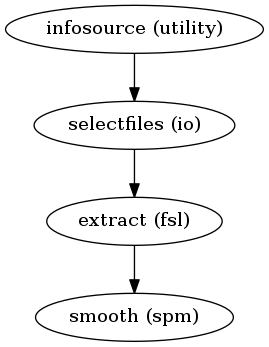

In [44]:
# preproc.write_graph(graph2use='colored', format='png', simple_form=True)
preproc.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

### checking different smooth methods

fslmath

In [10]:
smooth_img = nib.load('/output/smooth/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold_smooth.nii.gz')

In [11]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

In [12]:
print(header.get_data_shape())

(81, 96, 63, 242)


spm 

In [16]:
img_path = '/output/smooth_nomask/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii'
smooth_img = nib.load(img_path)

In [7]:
img_path = '/output/smooth/preproc/sub-29/ssub-29_task-tsl_run-3_fwhm-8_bold_masked.nii'
smooth_img = nib.load(img_path)

In [17]:
header = smooth_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 0.0)

In [18]:
print(header.get_data_shape())

(81, 96, 63, 242)


In [14]:
from nilearn.plotting import plot_anat, plot_epi, plot_img
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nb.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-2]/2) - 15

    # Plot the data
    plt.imshow(np.rot90(data[..., cut, 0]), cmap="gray")
    plt.gca().set_axis_off()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()


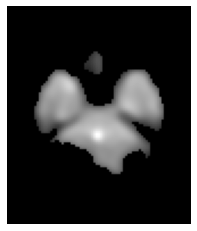

In [15]:
plot_slice(img_path)